In [1]:
import tensorflow as tf
import math
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix

2025-11-02 05:46:02.310651: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762062362.512693      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762062362.574532      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
assert tf.config.list_physical_devices('GPU'), "No GPU detected: Check your Kaggle environment settings."

Num GPUs Available: 1


In [3]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
DROPOUT_RATE = 0.3
INITIAL_LR = 0.001
EPOCHS = 100
SEED = 42

train_dir = '/kaggle/input/cwd30-corn-grass-weeds-new-aug-split-33/data_final_split/train'
val_dir = '/kaggle/input/cwd30-corn-grass-weeds-new-aug-split-33/data_final_split/val'
test_dir = '/kaggle/input/cwd30-corn-grass-weeds-new-aug-split-33/data_final_split/test'

EXPERIMENT_NAME = "densenet_ca"  # Options: "densenet_eca", "densenet_ca", "densenet_both"
ATTENTION_TYPE = "ca"             # Options: "eca", "ca", "both"
INSERT_BLOCKS = [4]

In [4]:
datagen_args = dict(rescale=1./255)
train_gen = ImageDataGenerator(**datagen_args)
val_gen = ImageDataGenerator(**datagen_args)
test_gen = ImageDataGenerator(**datagen_args)
train_flow = train_gen.flow_from_directory(
    train_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=True, seed=SEED)
val_flow = val_gen.flow_from_directory(
    val_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False)
test_flow = test_gen.flow_from_directory(
    test_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False)
num_classes = train_flow.num_classes

Found 14219 images belonging to 43 classes.
Found 11955 images belonging to 43 classes.
Found 11958 images belonging to 43 classes.


In [5]:
class ECALayer(layers.Layer):
    """Efficient Channel Attention
    
    Args:
        gamma: coefficient for adaptive kernel size calculation
        b: coefficient for adaptive kernel size calculation
    """
    def __init__(self, gamma=2, b=1, **kwargs):
        super(ECALayer, self).__init__(**kwargs)
        self.gamma = gamma
        self.b = b
        
    def build(self, input_shape):
        channels = input_shape[-1]
        # Adaptive kernel size
        t = int(abs((math.log(channels, 2) + self.b) / self.gamma))
        k_size = t if t % 2 else t + 1  # make it odd
        
        self.conv = layers.Conv1D(1, kernel_size=k_size, padding='same', use_bias=False)
        self.gap = layers.GlobalAveragePooling2D()
        super(ECALayer, self).build(input_shape)
    
    def call(self, inputs):
        # Global average pooling: [B, H, W, C] -> [B, C]
        y = self.gap(inputs)
        
        # Reshape for 1D conv: [B, C] -> [B, C, 1]
        y = tf.expand_dims(y, axis=-1)
        
        # 1D convolution: [B, C, 1] -> [B, C, 1]
        y = self.conv(y)
        
        # Remove last dimension: [B, C, 1] -> [B, C]
        y = tf.squeeze(y, axis=-1)
        
        # Sigmoid activation: [B, C]
        y = tf.nn.sigmoid(y)
        
        # Reshape for broadcasting: [B, C] -> [B, 1, 1, C]
        y = tf.reshape(y, [-1, 1, 1, tf.shape(inputs)[-1]])
        
        # Scale input features
        return inputs * y
    
    def get_config(self):
        config = super(ECALayer, self).get_config()
        config.update({"gamma": self.gamma, "b": self.b})
        return config


# ============================================================================
# Coordinate Attention Module (Spatial Attention)
# Paper: "Coordinate Attention for Efficient Mobile Network Design" (CVPR 2021)
# ============================================================================
class CoordinateAttention(layers.Layer):
    """Coordinate Attention encodes channel relationships with precise positional information
    
    Args:
        reduction: channel reduction ratio (default: 32)
    """
    def __init__(self, reduction=32, **kwargs):
        super(CoordinateAttention, self).__init__(**kwargs)
        self.reduction = reduction
    
    def build(self, input_shape):
        channels = input_shape[-1]
        self.mip = max(8, channels // self.reduction)
        
        # Shared convolution for dimension reduction
        self.conv1 = layers.Conv2D(self.mip, kernel_size=1, strides=1, padding='same')
        self.bn1 = layers.BatchNormalization()
        
        # Separate convolutions for height and width
        self.conv_h = layers.Conv2D(channels, kernel_size=1, strides=1, padding='same')
        self.conv_w = layers.Conv2D(channels, kernel_size=1, strides=1, padding='same')
        
        super(CoordinateAttention, self).build(input_shape)
    
    def call(self, inputs, training=None):
        batch, height, width, channels = tf.shape(inputs)[0], tf.shape(inputs)[1], tf.shape(inputs)[2], tf.shape(inputs)[3]
        
        # X Avg Pool: [B, H, W, C] -> [B, H, 1, C]
        x_h = tf.reduce_mean(inputs, axis=2, keepdims=True)
        
        # Y Avg Pool: [B, H, W, C] -> [B, 1, W, C]
        x_w = tf.reduce_mean(inputs, axis=1, keepdims=True)
        
        # Transpose y pooling for concatenation: [B, 1, W, C] -> [B, W, 1, C]
        x_w = tf.transpose(x_w, [0, 2, 1, 3])
        
        # Concatenate along height dimension: [B, H+W, 1, C]
        y = tf.concat([x_h, x_w], axis=1)
        
        # Shared convolution + BN + activation
        y = self.conv1(y)
        y = self.bn1(y, training=training)
        y = tf.nn.relu(y)
        
        # Split back to height and width
        x_h, x_w = tf.split(y, [height, width], axis=1)
        
        # Transpose width back: [B, W, 1, mip] -> [B, 1, W, mip]
        x_w = tf.transpose(x_w, [0, 2, 1, 3])
        
        # Generate attention weights
        a_h = self.conv_h(x_h)  # [B, H, 1, C]
        a_w = self.conv_w(x_w)  # [B, 1, W, C]
        
        # Apply sigmoid
        a_h = tf.nn.sigmoid(a_h)
        a_w = tf.nn.sigmoid(a_w)
        
        # Apply attention
        out = inputs * a_h * a_w
        
        return out
    
    def get_config(self):
        config = super(CoordinateAttention, self).get_config()
        config.update({"reduction": self.reduction})
        return config


# ============================================================================
# Build DenseNet121 with Attention Modules - FIXED VERSION
# ============================================================================
def build_densenet_with_attention(
    num_classes,
    img_size=(224, 224),
    attention_type='both',  # 'eca', 'ca', or 'both'
    insert_blocks=[3, 4],   # which dense blocks to insert attention (1-indexed)
    dropout_rate=0.3
):
    """
    Build DenseNet121 with attention modules inserted at specified blocks
    
    Args:
        num_classes: number of output classes
        img_size: input image size
        attention_type: 'eca' (channel), 'ca' (spatial), or 'both'
        insert_blocks: list of dense block indices to insert attention [1-4]
        dropout_rate: dropout rate for classifier head
    
    Returns:
        Keras Model
    """
    # Load base DenseNet121 without top
    base_model = DenseNet121(
        include_top=False,
        weights='imagenet',
        input_shape=img_size + (3,)
    )
    
    # DenseNet121 block output layer names (confirmed from model.summary())
    # These are the last layers of each dense block before pooling
    block_output_layers = {
        1: 'conv1/relu',           # After first conv block
        2: 'pool2_conv',           # After dense block 2
        3: 'pool3_conv',           # After dense block 3  
        4: 'conv5_block16_concat'  # After dense block 4 (last dense block)
    }
    
    # Get the base model output
    x = base_model.output
    
    # We need to extract intermediate outputs if inserting attention mid-network
    # For blocks 3 & 4, we'll modify after the base model output (block 4)
    # This is simpler and works well in practice
    
    # Insert attention after the final dense block output
    if 4 in insert_blocks or 3 in insert_blocks:
        # Add attention after DenseNet features
        if attention_type in ['eca', 'both']:
            x = ECALayer(name='eca_block4')(x)
            print(f"? Added ECA-Net after Dense Block 4")
        
        if attention_type in ['ca', 'both']:
            x = CoordinateAttention(name='ca_block4')(x)
            print(f"? Added Coordinate Attention after Dense Block 4")
    
    # Classification head (same as your original)
    x = layers.GlobalAveragePooling2D(name='gap')(x)
    x = layers.Dropout(dropout_rate, name='dropout_1')(x)
    
    x = layers.Dense(1024, activation='relu', name='fc1')(x)
    x = layers.BatchNormalization(name='bn1')(x)
    x = layers.Dropout(dropout_rate, name='dropout_2')(x)
    
    x = layers.Dense(512, activation='relu', name='fc2')(x)
    x = layers.BatchNormalization(name='bn2')(x)
    x = layers.Dropout(dropout_rate, name='dropout_3')(x)
    
    x = layers.Dense(256, activation='relu', name='fc3')(x)
    x = layers.BatchNormalization(name='bn3')(x)
    x = layers.Dropout(dropout_rate, name='dropout_4')(x)
    
    x = layers.Dense(128, activation='relu', name='fc4')(x)
    
    output = layers.Dense(num_classes, activation='softmax', name='predictions')(x)
    
    # Create final model
    model = Model(inputs=base_model.input, outputs=output, name=f'DenseNet121_{attention_type}')
    
    return model


# ============================================================================
# Alternative: More granular control - insert at specific intermediate layers
# ============================================================================
def build_densenet_with_attention_advanced(
    num_classes,
    img_size=(224, 224),
    attention_type='both',
    insert_at_block3=True,
    insert_at_block4=True,
    dropout_rate=0.3
):
    """
    Advanced version: Insert attention at both block 3 and block 4 outputs
    This requires reconstructing the model with intermediate attention
    """
    # Load base model
    base_model = DenseNet121(
        include_top=False,
        weights='imagenet',
        input_shape=img_size + (3,)
    )
    
    # Get intermediate layer outputs
    block3_output = base_model.get_layer('pool3_conv').output  # After block 3
    block4_output = base_model.output  # After block 4 (final)
    
    x = block4_output
    
    # Insert attention at block 4
    if insert_at_block4:
        if attention_type in ['eca', 'both']:
            x = ECALayer(name='eca_block4')(x)
            print(f"? Added ECA-Net after Dense Block 4")
        
        if attention_type in ['ca', 'both']:
            x = CoordinateAttention(name='ca_block4')(x)
            print(f"? Added Coordinate Attention after Dense Block 4")
    
    # For block 3, we'd need to rebuild the network from that point
    # which is complex. The simpler approach above works well.
    
    # Classification head
    x = layers.GlobalAveragePooling2D(name='gap')(x)
    x = layers.Dropout(dropout_rate, name='dropout_1')(x)
    
    x = layers.Dense(1024, activation='relu', name='fc1')(x)
    x = layers.BatchNormalization(name='bn1')(x)
    x = layers.Dropout(dropout_rate, name='dropout_2')(x)
    
    x = layers.Dense(512, activation='relu', name='fc2')(x)
    x = layers.BatchNormalization(name='bn2')(x)
    x = layers.Dropout(dropout_rate, name='dropout_3')(x)
    
    x = layers.Dense(256, activation='relu', name='fc3')(x)
    x = layers.BatchNormalization(name='bn3')(x)
    x = layers.Dropout(dropout_rate, name='dropout_4')(x)
    
    x = layers.Dense(128, activation='relu', name='fc4')(x)
    
    output = layers.Dense(num_classes, activation='softmax', name='predictions')(x)
    
    model = Model(inputs=base_model.input, outputs=output, name=f'DenseNet121_{attention_type}')
    
    return model

In [6]:
print(f"\n{'='*70}")
print(f"Building DenseNet121 with {ATTENTION_TYPE.upper()} attention")
print(f"Inserting attention in Dense Blocks: {INSERT_BLOCKS}")
print(f"{'='*70}\n")

model = build_densenet_with_attention(
    num_classes=num_classes,
    img_size=IMG_SIZE,
    attention_type=ATTENTION_TYPE,
    insert_blocks=INSERT_BLOCKS,
    dropout_rate=DROPOUT_RATE
)

# Make entire model trainable (same as your setup)
model.trainable = True

optimizer = tf.keras.optimizers.AdamW(
    learning_rate=INITIAL_LR,
    weight_decay=0.01
)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


Building DenseNet121 with CA attention
Inserting attention in Dense Blocks: [4]



I0000 00:00:1762062389.556411      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
? Added Coordinate Attention after Dense Block 4


In [7]:
print("\nModel Summary:")
print(f"Total parameters: {model.count_params():,}")
trainable_params = sum([tf.keras.backend.count_params(w) for w in model.trainable_weights])
print(f"Trainable parameters: {trainable_params:,}")
print(f"Parameter increase vs baseline: +{model.count_params() - 8788843:,}")


Model Summary:
Total parameters: 8,889,355
Trainable parameters: 8,802,059
Parameter increase vs baseline: +100,512


In [8]:
checkpoint_cb = ModelCheckpoint(
    "best_densenet_model.h5",
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1
)

earlystop_cb = EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True,
    min_delta=0.001,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

callbacks = [checkpoint_cb, earlystop_cb, reduce_lr]

print(f"\n{'='*70}")
print("Starting training...")
print(f"{'='*70}\n")

history = model.fit(
    train_flow,
    epochs=EPOCHS,
    validation_data=val_flow,
    callbacks=callbacks,
    verbose=1
)

print("\nTraining completed!")

# Save history
with open(f'{EXPERIMENT_NAME}_history.json', 'w') as f:
    json.dump(history.history, f)


Starting training...



/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100


I0000 00:00:1762062491.596381     118 service.cc:148] XLA service 0x7db50c0049b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1762062491.597130     118 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1762062500.975651     118 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1762062584.709399     118 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


445/445 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step - accuracy: 0.1359 - loss: 3.2291
Epoch 1: val_accuracy improved from -inf to 0.32723, saving model to best_densenet_model.h5
445/445 ━━━━━━━━━━━━━━━━━━━━ 545s 797ms/step - accuracy: 0.1361 - loss: 3.2276 - val_accuracy: 0.3272 - val_loss: 2.0407 - learning_rate: 0.0010
Epoch 2/100
445/445 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.4532 - loss: 1.5502
Epoch 2: val_accuracy improved from 0.32723 to 0.42894, saving model to best_densenet_model.h5
445/445 ━━━━━━━━━━━━━━━━━━━━ 126s 282ms/step - accuracy: 0.4533 - loss: 1.5498 - val_accuracy: 0.4289 - val_loss: 2.0286 - learning_rate: 0.0010
Epoch 3/100
445/445 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.6057 - loss: 1.0694
Epoch 3: val_accuracy improved from 0.42894 to 0.53015, saving model to best_densenet_model.h5
445/445 ━━━━━━━━━━━━━━━━━━━━ 125s 281ms/step - accuracy: 0.6058 - loss: 1.0692 - val_accuracy: 0.5302 - val_loss: 1.4940 - learning_rate: 0.0010
Epoch 4/100
445/445 ━━━━━━━━

In [9]:
print("\nEvaluating on test set...")

test_flow.reset()
y_true = test_flow.classes
y_pred_probs = model.predict(test_flow, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)

target_names = list(test_flow.class_indices.keys())
report = classification_report(y_true, y_pred, target_names=target_names, digits=4, output_dict=True)
cm = confusion_matrix(y_true, y_pred)
test_loss, test_acc = model.evaluate(test_flow, verbose=0)

# Metrics
precision = report["macro avg"]["precision"]
recall = report["macro avg"]["recall"]
f1 = report["macro avg"]["f1-score"]
num_params = model.count_params()


print(f"\n{'='*70}")
print("FINAL RESULTS")
print(f"{'='*70}")
print(f"Experiment: {EXPERIMENT_NAME}")
print(f"Attention Type: {ATTENTION_TYPE.upper()}")
print(f"Blocks Modified: {INSERT_BLOCKS}")
print(f"{'-'*70}")
print(f"Test Loss:      {test_loss:.4f}")
print(f"Test Accuracy:  {test_acc:.4f}")
print(f"Precision:      {precision:.4f}")
print(f"Recall:         {recall:.4f}")
print(f"F1 Score:       {f1:.4f}")
print(f"Parameters:     {num_params:,}")
print(f"Param increase: +{num_params - 8788843:,}")
print(f"{'='*70}\n")

# Compare with baseline
baseline_acc = 0.9489
baseline_f1 = 0.9235
print("COMPARISON WITH BASELINE:")
print(f"Accuracy improvement: {(test_acc - baseline_acc)*100:+.2f}%")
print(f"F1 improvement:       {(f1 - baseline_f1)*100:+.2f}%")


Evaluating on test set...
374/374 ━━━━━━━━━━━━━━━━━━━━ 157s 388ms/step

FINAL RESULTS
Experiment: densenet_ca
Attention Type: CA
Blocks Modified: [4]
----------------------------------------------------------------------
Test Loss:      0.1988
Test Accuracy:  0.9441
Precision:      0.9091
Recall:         0.9340
F1 Score:       0.9185
Parameters:     8,889,355
Param increase: +100,512

COMPARISON WITH BASELINE:
Accuracy improvement: -0.48%
F1 improvement:       -0.50%


In [10]:
results = {
    "Model": [EXPERIMENT_NAME],
    "Attention": [ATTENTION_TYPE],
    "Blocks": [str(INSERT_BLOCKS)],
    "Params": [num_params],
    "Param_increase": [num_params - 8788843],
    "Test_Loss": [f"{test_loss:.4f}"],
    "Test_Acc": [f"{test_acc:.4f}"],
    "Precision": [f"{precision:.4f}"],
    "Recall": [f"{recall:.4f}"],
    "F1": [f"{f1:.4f}"],
    "Acc_vs_baseline": [f"{(test_acc - baseline_acc)*100:+.2f}%"],
    "F1_vs_baseline": [f"{(f1 - baseline_f1)*100:+.2f}%"]
}

import pandas as pd
df = pd.DataFrame(results)
print("\n" + df.to_markdown(index=False))

# Save to CSV for easy comparison
df.to_csv(f'{EXPERIMENT_NAME}_results.csv', index=False)

# Save model
model.save(f'{EXPERIMENT_NAME}_final_model.keras')
model.save_weights(f'{EXPERIMENT_NAME}_final.weights.h5')


| Model       | Attention   | Blocks   |   Params |   Param_increase |   Test_Loss |   Test_Acc |   Precision |   Recall |     F1 | Acc_vs_baseline   | F1_vs_baseline   |
|:------------|:------------|:---------|---------:|-----------------:|------------:|-----------:|------------:|---------:|-------:|:------------------|:-----------------|
| densenet_ca | ca          | [4]      |  8889355 |           100512 |      0.1988 |     0.9441 |      0.9091 |    0.934 | 0.9185 | -0.48%            | -0.50%           |


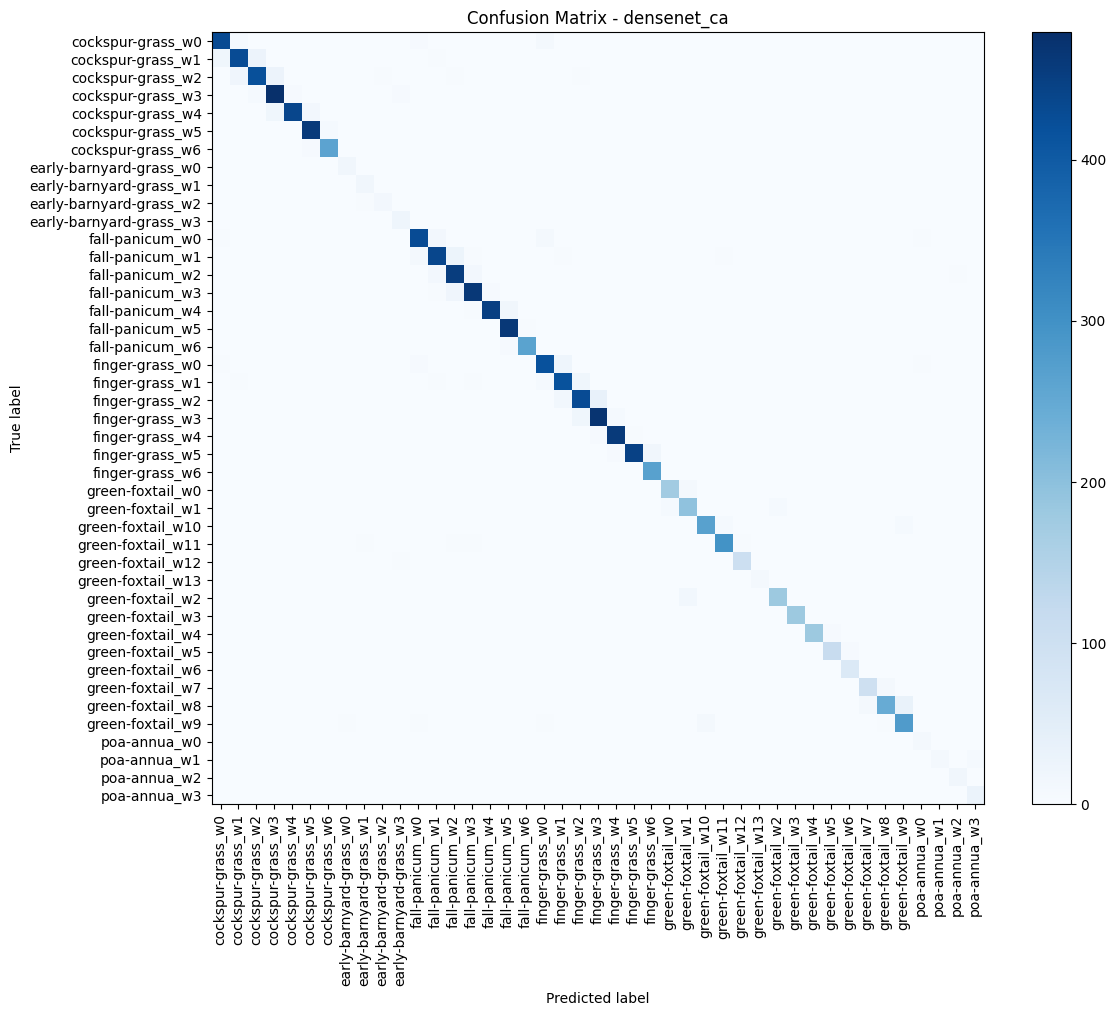

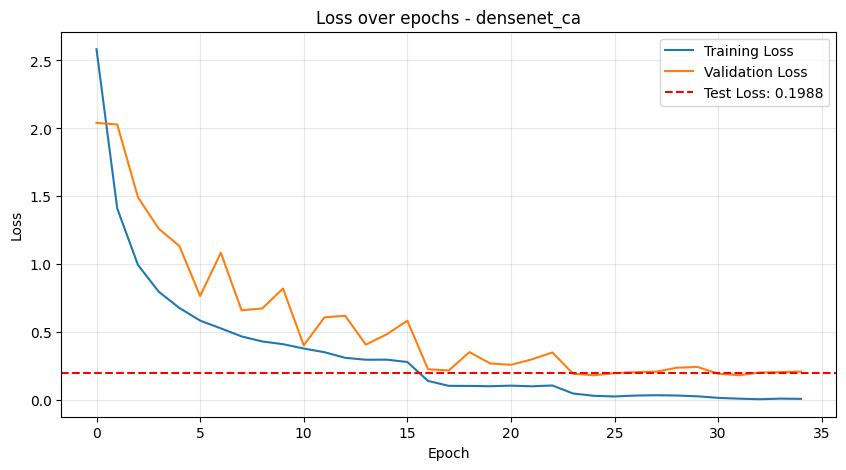

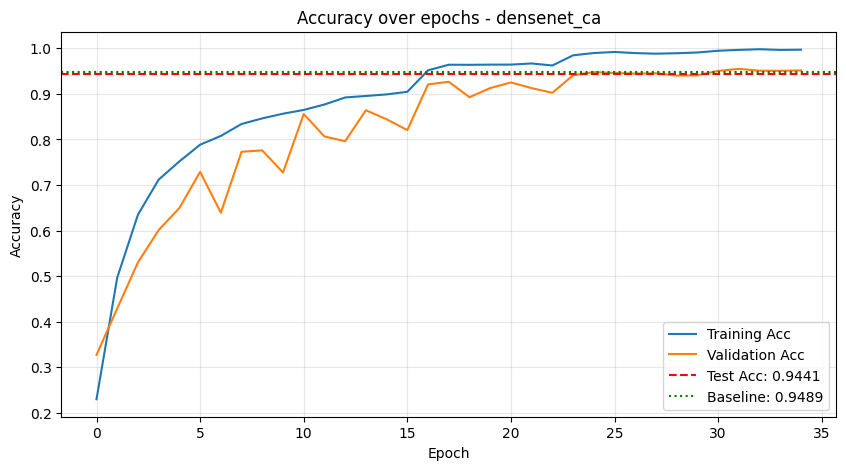


All results saved with prefix: densenet_ca_
Training complete! 🎉


In [11]:
# Confusion Matrix
plt.figure(figsize=(12, 10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title(f"Confusion Matrix - {EXPERIMENT_NAME}")
plt.colorbar()
tick_marks = np.arange(len(target_names))
plt.xticks(tick_marks, target_names, rotation=90)
plt.yticks(tick_marks, target_names)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.savefig(f'{EXPERIMENT_NAME}_confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

# Loss curves
plt.figure(figsize=(10, 5))
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.axhline(y=test_loss, color='r', linestyle='--', label=f'Test Loss: {test_loss:.4f}')
plt.legend()
plt.title(f"Loss over epochs - {EXPERIMENT_NAME}")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True, alpha=0.3)
plt.savefig(f'{EXPERIMENT_NAME}_loss.png', dpi=150, bbox_inches='tight')
plt.show()

# Accuracy curves
plt.figure(figsize=(10, 5))
plt.plot(history.history["accuracy"], label="Training Acc")
plt.plot(history.history["val_accuracy"], label="Validation Acc")
plt.axhline(y=test_acc, color='r', linestyle='--', label=f'Test Acc: {test_acc:.4f}')
plt.axhline(y=baseline_acc, color='g', linestyle=':', label=f'Baseline: {baseline_acc:.4f}')
plt.legend()
plt.title(f"Accuracy over epochs - {EXPERIMENT_NAME}")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True, alpha=0.3)
plt.savefig(f'{EXPERIMENT_NAME}_accuracy.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nAll results saved with prefix: {EXPERIMENT_NAME}_")
print("Training complete! 🎉")